In [1]:
import sys
sys.path.append("..")

from models.nn_models import *
from models.datasets import TreePartNetOriginalDataset
from data.utils import distinct_colors

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [36]:
treepartnet = TreePartNet.load_from_checkpoint("/space/ariyanzarei/sorghum_segmentation/models/other_datasets_model_checkpoints/TPN/TreePartNet/lightning_logs/version_0/checkpoints/epoch=9-step=8809.ckpt")
treepartnet = treepartnet.cuda()

spn = SorghumPartNetInstance.load_from_checkpoint("/space/ariyanzarei/sorghum_segmentation/models/other_datasets_model_checkpoints/TPN/SorghumPartNetInstance/lightning_logs/version_0/checkpoints/epoch=9-step=4409.ckpt")
spn = spn.cuda()

In [66]:
dataset = TreePartNetOriginalDataset("/space/ariyanzarei/sorghum_segmentation/dataset/TreePartNetData/tree_labeled_val.hdf5")

In [76]:
metric_calc = LeafMetrics("cpu")

In [120]:
ind = 68

points, branch_label, affinity_matrix = dataset[ind]
points = points.unsqueeze(0).cuda()
print(points.shape)


torch.Size([1, 8000, 3])


In [121]:
preds = treepartnet(points)
spn_preds = spn(points.double())

In [122]:
branch_pred = preds[0]
branch_pred = torch.argmax(branch_pred,1).squeeze()

tensor(622, device='cuda:0')
tensor([ 72, 238, 127,  ..., 238, 129, 127])
tensor([72,  2,  7,  ...,  2,  1,  7], device='cuda:0')
(0.9521557688713074, 0.6956644058227539, 0.49670231342315674, 0.5795836448669434)
(0.8155593872070312, 0.20447416603565216, 0.6150636672973633, 0.3069159686565399)
(0.8155593872070312, 0.20447416603565216, 0.6150636672973633, 0.3069159686565399)


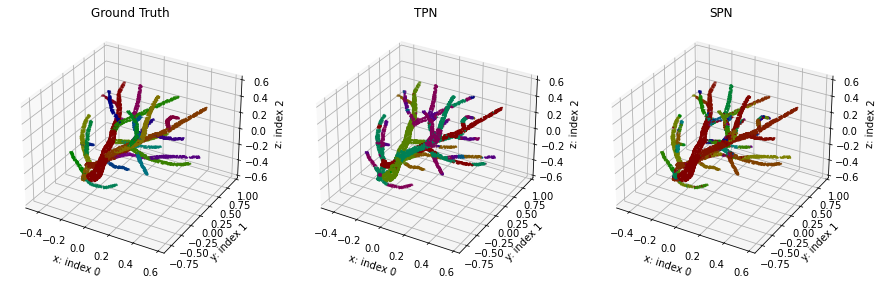

In [129]:

points, branch_label, affinity_matrix = dataset[ind]

spn_preds_cpu = spn_preds.cpu().detach().numpy().squeeze()
clustering = DBSCAN(eps=1.58, min_samples=3).fit(spn_preds_cpu)
labels_spn = clustering.labels_

res_spn = metric_calc(torch.from_numpy(labels_spn).unsqueeze(0).unsqueeze(-1).cpu(), branch_label.unsqueeze(0).unsqueeze(-1))
res_tpn_old = metric_calc(branch_pred.unsqueeze(0).unsqueeze(-1).cpu(), branch_label.unsqueeze(0).unsqueeze(-1))

tpn_fnode = preds[1]
tpn_fnode = (tpn_fnode>0).int().squeeze()
tpn_final = branch_pred.squeeze().cpu()
print(tpn_fnode.sum())
for i in range(256):
    for j, v in enumerate(tpn_fnode[i]):
        if v == 1:
            tpn_final[tpn_final == j] = i

print(tpn_final)
print(branch_pred)
res_tpn = metric_calc(tpn_final.unsqueeze(0).unsqueeze(-1).cpu(), branch_label.unsqueeze(0).unsqueeze(-1))

print(res_spn)
print(res_tpn_old)
print(res_tpn)

labels_gt = branch_label.squeeze().cpu()
labels_tpn = tpn_final.squeeze().cpu()

d_colors = distinct_colors(len(set(labels_gt.tolist())))
colors_gt = np.zeros((labels_gt.shape[0], 3))
for i, l in enumerate(list(set(labels_gt.tolist()))):
    colors_gt[labels_gt == l, :] = d_colors[i]

d_colors = distinct_colors(len(set(labels_tpn.tolist())))
colors_tpn = np.zeros((labels_tpn.shape[0], 3))
for i, l in enumerate(list(set(labels_tpn.tolist()))):
    colors_tpn[labels_tpn == l, :] = d_colors[i]

d_colors = distinct_colors(len(set(labels_spn.tolist())))
colors_spn = np.zeros((labels_spn.shape[0], 3))
for i, l in enumerate(list(set(labels_spn.tolist()))):
    colors_spn[labels_spn == l, :] = d_colors[i]

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.scatter(points[:,0],points[:,1],points[:,2], s=1, c=colors_gt)
ax1.set_xlabel("x: index 0")
ax1.set_ylabel("y: index 1")
ax1.set_zlabel("z: index 2")
ax1.set_title("Ground Truth")

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.scatter(points[:,0],points[:,1],points[:,2], s=1, c=colors_tpn)
ax2.set_xlabel("x: index 0")
ax2.set_ylabel("y: index 1")
ax2.set_zlabel("z: index 2")
ax2.set_title("TPN")

ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.scatter(points[:,0],points[:,1],points[:,2], s=1, c=colors_spn)
ax3.set_xlabel("x: index 0")
ax3.set_ylabel("y: index 1")
ax3.set_zlabel("z: index 2")
ax3.set_title("SPN")

plt.show()